# Dense vs Convolutional Neural Networks


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt

torch.random.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


Link to the data:
https://drive.google.com/file/d/1j9QSpZHua5KP_Bw2iP8CD9c0ewjHYobQ/view?usp=sharing

_(this is a subset of "skin-cancer-mnist-ham10000")_


Read the CSV file and display the first few rows of the data.

In [2]:
os.chdir('..')
os.listdir()

['.git',
 '.gitignore',
 'data',
 'DCE',
 'EDT HSB 2024-2025 rev16.xls',
 'Extra',
 'Planning DL&NLP.xls',
 'README.md',
 'Slides',
 'TD']

In [3]:
df = pd.read_csv("data/HAM2000/metadata.csv")
full_name = {
    "bcc": "Basal cell carcinoma",
    "bkl": "Benign keratosis-like lesions",
    "mel": "Melanoma",
    "nv": "Melanocytic nevi",
}
df["dx_full"] = df["dx"].map(full_name.get)
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_full
0,HAM_0006518,ISIC_0027618,nv,follow_up,35.0,male,back,Melanocytic nevi
1,HAM_0004666,ISIC_0029165,nv,follow_up,55.0,male,upper extremity,Melanocytic nevi
2,HAM_0006455,ISIC_0029690,nv,follow_up,50.0,male,lower extremity,Melanocytic nevi
3,HAM_0003653,ISIC_0030139,nv,histo,45.0,male,back,Melanocytic nevi
4,HAM_0001330,ISIC_0026818,nv,histo,20.0,female,abdomen,Melanocytic nevi


Create a dataset with a transformation to resize the images to 64x64 pixels.

Add data augmentation (random horizontal/vertical flip) to the dataset.

In [4]:
transfo = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]
)
dataset = torchvision.datasets.ImageFolder(root="data/HAM2000/", transform=transfo)
class_names = [full_name[name] for name in dataset.find_classes("data/HAM2000/")[0]]


Split the dataset into training and test sets.

Create dataloaders for the training and test sets.

In [5]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)


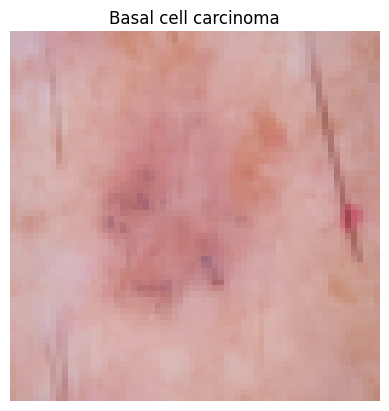

In [6]:
image, label = dataset[0]
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off")
plt.show()


### Linear Model

Create a linear model with two hidden layer.

In [7]:
class SkinLinearNet(nn.Module):
    def __init__(self, hidden_size1=512, hidden_size2=32):
        super().__init__()
        self.fc0 = nn.Linear(3*64*64, hidden_size1)
        self.fc1 = nn.Linear(hidden_size1, hidden_size2)
        self.fc2 = nn.Linear(hidden_size2, 4)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = x.view(-1, 3*64*64)
        x = self.relu(self.fc0(x))
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

Create a loss function and an optimizer.

In [8]:
model = SkinLinearNet()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
losses = []
accuracies = [0.25]

Write the training loop.

In [9]:
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    correct_count = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        hot_outputs = model(images)
        outputs = hot_outputs.argmax(axis=1)
        correct_count += (outputs == labels).sum().item()
        loss = criterion(hot_outputs, labels)
        loss.backward()
        losses.append(loss.item())
        running_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
    accuracy = correct_count/train_size
    accuracies.append(accuracy)
    print(f"Epoch [{epoch}/{num_epochs}] Loss: {running_loss:.6f} Accuracy: {accuracy*100:.2f}%")


Epoch [1/10] Loss: 34.649231 Accuracy: 27.06%
Epoch [2/10] Loss: 34.346856 Accuracy: 33.50%
Epoch [3/10] Loss: 34.046169 Accuracy: 37.38%
Epoch [4/10] Loss: 33.624494 Accuracy: 37.25%
Epoch [5/10] Loss: 33.127087 Accuracy: 41.12%
Epoch [6/10] Loss: 32.665159 Accuracy: 44.69%
Epoch [7/10] Loss: 32.154407 Accuracy: 47.44%
Epoch [8/10] Loss: 31.960557 Accuracy: 46.38%
Epoch [9/10] Loss: 31.649297 Accuracy: 46.31%
Epoch [10/10] Loss: 31.410026 Accuracy: 48.62%


Plot the loss and accuracy through epochs.

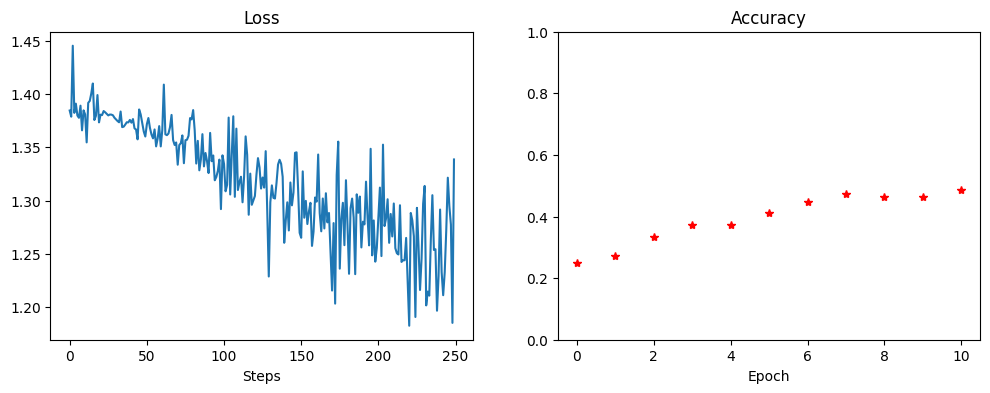

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("Loss")
plt.xlabel("Steps")
plt.subplot(1,2,2)
plt.plot(accuracies, '*r')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylim(0, 1)
plt.show()


Test the model on a few images of the test set.

In [ ]:
small_class_names = dataset.find_classes("data/HAM2000/")[0]
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    predictions = model(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        ax.imshow(images[i].cpu().numpy().swapaxes(0, 2).swapaxes(0, 1))
        pred_class = small_class_names[torch.argmax(predictions[i])]
        real_class = small_class_names[labels[i]]
        ax.set_title(f"{pred_class} - {real_class}")
        plt.axis("off")
    plt.suptitle("predicted - real")
    plt.show()
    break


Compute the accuracy of the model on the test set.

In [ ]:
correct = 0
total = 0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    predictions = model(images)
    total += labels.size(0)
    correct += (torch.argmax(predictions, dim=1) == labels).sum().item()

print(f"Accuracy: {100*correct/total:.2f} %")


### Conv Model

Create a convolutional model with a few convolutional layers and two linear layers (for the classification).

In [11]:
class SkinConvNet(nn.Module):
    def __init__(self, hidden_size=64):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, stride=2)
        self.conv2 = nn.Conv2d(8, 16, 5, stride=1)
        self.conv3 = nn.Conv2d(16, 32, 5, stride=1)
        self.conv4 = nn.Conv2d(32, 32, 5, stride=1)
        self.conv5 = nn.Conv2d(32, 32, 5, stride=1)
        self.fc1 = nn.Linear(14 * 14 * 32, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 4)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        # print(x.shape)
        x = x.view(-1, 14 * 14 * 32)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x


Create a loss function and an optimizer.

In [12]:
model = SkinConvNet()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
losses = []
accuracies = [0.25]

Write the training loop.

In [13]:
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    correct_count = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        hot_outputs = model(images)
        outputs = hot_outputs.argmax(axis=1)
        correct_count += (outputs == labels).sum().item()
        loss = criterion(hot_outputs, labels)
        loss.backward()
        losses.append(loss.item())
        running_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
    accuracy = correct_count/train_size
    accuracies.append(accuracy)
    print(f"Epoch [{epoch}/{num_epochs}] Loss: {running_loss:.6f} Accuracy: {accuracy*100:.2f}%")


Epoch [1/10] Loss: 34.622593 Accuracy: 29.50%
Epoch [2/10] Loss: 34.119688 Accuracy: 35.31%
Epoch [3/10] Loss: 32.772481 Accuracy: 38.44%
Epoch [4/10] Loss: 32.437342 Accuracy: 39.62%
Epoch [5/10] Loss: 32.064594 Accuracy: 41.06%
Epoch [6/10] Loss: 31.628634 Accuracy: 43.00%
Epoch [7/10] Loss: 31.720251 Accuracy: 43.50%
Epoch [8/10] Loss: 31.519983 Accuracy: 44.31%
Epoch [9/10] Loss: 31.725008 Accuracy: 42.69%
Epoch [10/10] Loss: 31.397577 Accuracy: 45.12%


Plot the loss and accuracy through epochs.

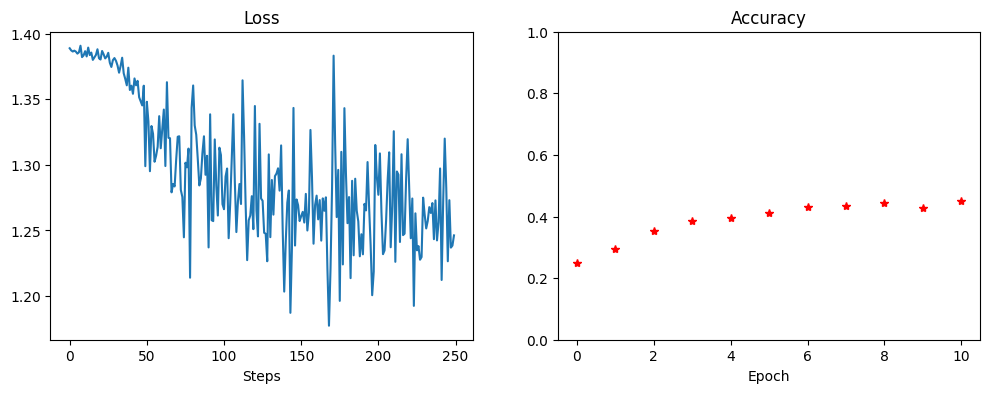

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("Loss")
plt.xlabel("Steps")
plt.subplot(1,2,2)
plt.plot(accuracies, '*r')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylim(0, 1)
plt.show()


Test the model on a few images of the test set.

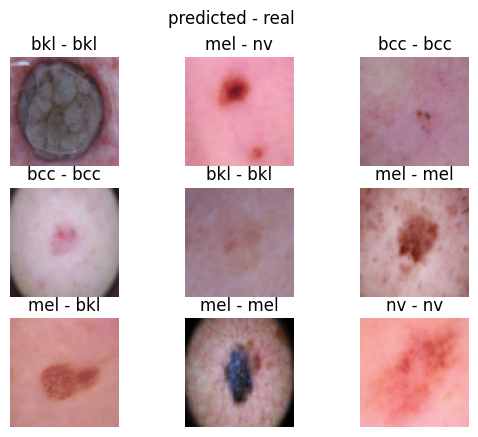

In [16]:
small_class_names = dataset.find_classes("data/HAM2000/")[0]
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    predictions = model(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        ax.imshow(images[i].cpu().numpy().swapaxes(0, 2).swapaxes(0, 1))
        pred_class = small_class_names[torch.argmax(predictions[i])]
        real_class = small_class_names[labels[i]]
        ax.set_title(f"{pred_class} - {real_class}")
        plt.axis("off")
    plt.suptitle("predicted - real")
    plt.show()
    break


Compute the accuracy of the model on the test set.

In [17]:
correct = 0
total = 0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    predictions = model(images)
    total += labels.size(0)
    correct += (torch.argmax(predictions, dim=1) == labels).sum().item()

print(f"Accuracy: {100*correct/total:.2f} %")


Accuracy: 46.00 %


Compare the training time and accuracy of the two models.

-----

BONUS: Create a custom dataset and return the image, the class, and some tabular data from the CSV file.

You may use the 'bis' version of the dataset for this task: https://drive.google.com/file/d/1YIcfChTKgDHyr4XMaxuCFYWtRVo_fNbN/view?usp=sharing

Create a model that uses the tabular data and the image to predict the class.

Create a loss function and an optimizer.

Write the training loop.

Plot the loss and accuracy through epochs.

Test the model on a few images of the test set.

Compute the accuracy of the model on the test set.